## 导入实验所需模块

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import platform
import sys
from six.moves import cPickle as pickle

In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Activation
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from tensorflow.keras import backend as K

Using TensorFlow backend.


## 自定义加载数据函数

In [4]:
def load_batch(fpath, label_key='labels'):
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]
 
    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

In [5]:
def load_data(ROOT):
    path = ROOT
    num_train_samples = 50000 
    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8') 
    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)
 
    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath) 
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))
    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1) 
    return (x_train, y_train), (x_test, y_test)

## 加载数据

In [6]:
(X_train, y_train), (X_test, y_test) = load_data('./dataset')

## 查看数据形状、类型

In [7]:
print(X_train.shape,y_train.shape)
print(type(X_train),type(y_train))

(50000, 32, 32, 3) (50000, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## 查看前十张图片

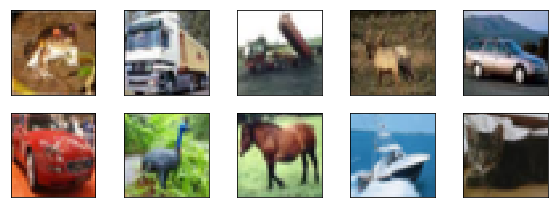

In [8]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

## 选择所有的汽车图片

In [9]:
idx = np.where(y_train[:]==1)[0]
X_train = X_train[idx,::]

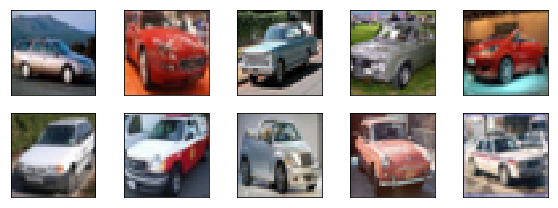

In [10]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

## 图片预处理

In [11]:
num_classes = 10
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = c.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# 将标签转化为热编码形式
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# 将图像每一位像素设定在[-1,1]之间（为了使用tanh函数）
X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

## 定义生成器

In [12]:
# 噪声z初始维度
latent_dim = 100
#权重初始化为均值为0，标准差为0.02的正态分布
init = initializers.RandomNormal(stddev=0.02)

# 开始建立生成网络
generator = Sequential()

# 第一层使用全连接，其余层使用微步幅度卷积、批处理
# 最后一层使用tanhx激活函数，其余层均使用RuLu激活函数

# 1x100 ——> 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
# 2x2x512 ——> 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
# 4x4x256 ——> 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
# 8x8x128 ——> 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
# 6x16x64 ——> 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same'))
#generator.add(BatchNormalization())
generator.add(Activation('tanh'))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# 查看判别网络细节
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_2 (Activation)    (None, 4, 4, 256)         0         
__________

## 定义判别器

In [14]:
# 判别器输入图像的形状
img_shape = X_train[0].shape

# 开始建立判别网络
discriminator = Sequential()
#使用步幅卷积代替池化层
#除最后一层使用使用sigmoid激活函数，其余层均使用LeakyRelu函数作为激活函数

# 32x32x3 ——> 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
#discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 16x16x64 ——> 8x8x128
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 8x8x128 ——> 4x4x256
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 4x4x256 ——> 2x2x512
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 2x2x512 ——> 2048
discriminator.add(Flatten())
# 输出使用FC，为一维
discriminator.add(Dense(1, activation='sigmoid'))

In [15]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 256)         1024      
__________

## 判别器优化器，形成最优的D

In [16]:
# 优化器:Adam优化器，学习率0.0002，动量0.5
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

## 连接生成器和判别器，构建DCGAN网络

In [17]:
discriminator.trainable = False
z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

In [18]:
# DCGAN网络细节
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         4516739   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 4312193   
Total params: 8,828,932
Trainable params: 4,514,819
Non-trainable params: 4,314,113
_________________________________________________________________


## DCGAN优化器，形成最优的G

In [19]:
d_g.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

## 训练

Instructions for updating:
Use tf.cast instead.
epoch = 1/300, d_loss=0.173, g_loss=0.053                                                                                                                       


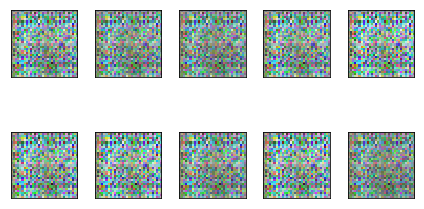

epoch = 2/300, d_loss=0.265, g_loss=1.563                                                                                                                       
epoch = 3/300, d_loss=0.224, g_loss=5.209                                                                                                                       
epoch = 4/300, d_loss=0.196, g_loss=0.051                                                                                                                                                                                                                         
epoch = 5/300, d_loss=0.190, g_loss=0.469                                                                                                                      
epoch = 6/300, d_loss=0.168, g_loss=0.086                                                                                                                      
epoch = 7/300, d_loss=0.265, g_loss=0.038                                                          

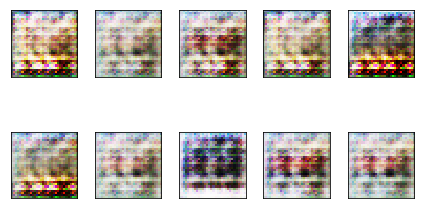

epoch = 12/300, d_loss=1.408, g_loss=13.543                                                                                                                      
epoch = 13/300, d_loss=0.175, g_loss=0.017                                                                                                                      
epoch = 14/300, d_loss=0.281, g_loss=2.970                                                                                                                      
epoch = 15/300, d_loss=0.447, g_loss=2.968                                                                                                                      
epoch = 16/300, d_loss=0.368, g_loss=1.748                                                                                                                       
epoch = 17/300, d_loss=0.317, g_loss=4.048                                                                                                                      
epoch = 18/300, d_loss=0.265, g_

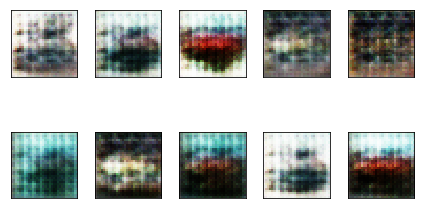

epoch = 22/300, d_loss=0.339, g_loss=0.935                                                                                                                       
epoch = 23/300, d_loss=0.288, g_loss=2.603                                                                                                                       
epoch = 24/300, d_loss=0.231, g_loss=0.283                                                                                                                       
epoch = 25/300, d_loss=0.325, g_loss=8.849                                                                                                                       
epoch = 26/300, d_loss=0.421, g_loss=6.183                                                                                                                       
epoch = 27/300, d_loss=0.200, g_loss=1.011                                                                                                                      
epoch = 28/300, d_loss=0.215,

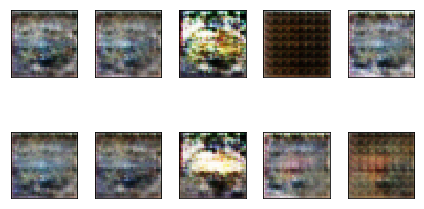

epoch = 32/300, d_loss=0.220, g_loss=7.798                                                                                                                       
epoch = 33/300, d_loss=0.488, g_loss=5.601                                                                                                                      
epoch = 34/300, d_loss=0.182, g_loss=0.169                                                                                                                      
epoch = 35/300, d_loss=0.197, g_loss=1.043                                                                                                                      
epoch = 36/300, d_loss=0.392, g_loss=4.881                                                                                                                       
epoch = 37/300, d_loss=0.263, g_loss=4.945                                                                                                                      
epoch = 38/300, d_loss=0.216, g_

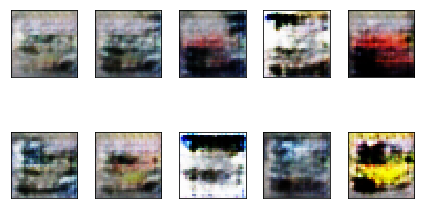

epoch = 42/300, d_loss=0.246, g_loss=0.381                                                                                                                       
epoch = 43/300, d_loss=0.210, g_loss=3.238                                                                                                                      
epoch = 44/300, d_loss=0.184, g_loss=5.037                                                                                                                      
epoch = 45/300, d_loss=0.430, g_loss=4.213                                                                                                                       
epoch = 46/300, d_loss=0.190, g_loss=0.567                                                                                                                       
epoch = 47/300, d_loss=0.180, g_loss=0.089                                                                                                                       
epoch = 48/300, d_loss=0.169, 

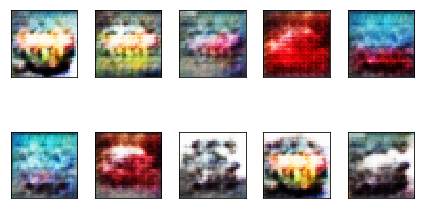

epoch = 52/300, d_loss=0.173, g_loss=3.751                                                                                                                      
epoch = 53/300, d_loss=0.182, g_loss=0.125                                                                                                                       
epoch = 54/300, d_loss=0.171, g_loss=0.043                                                                                                                       
epoch = 55/300, d_loss=0.175, g_loss=1.618                                                                                                                      
epoch = 56/300, d_loss=0.213, g_loss=1.474                                                                                                                      
epoch = 57/300, d_loss=0.212, g_loss=0.447                                                                                                                      
epoch = 58/300, d_loss=0.174, g_

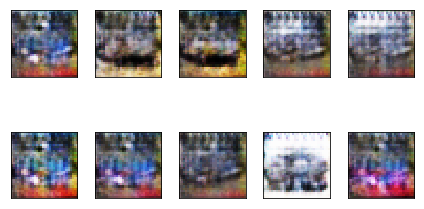

epoch = 62/300, d_loss=0.210, g_loss=5.379                                                                                                                       
epoch = 63/300, d_loss=0.208, g_loss=1.680                                                                                                                       
epoch = 64/300, d_loss=0.201, g_loss=1.159                                                                                                                       
epoch = 65/300, d_loss=0.182, g_loss=0.179                                                                                                                      
epoch = 66/300, d_loss=0.195, g_loss=0.866                                                                                                                      
epoch = 67/300, d_loss=0.245, g_loss=3.301                                                                                                                      
epoch = 68/300, d_loss=0.190, g

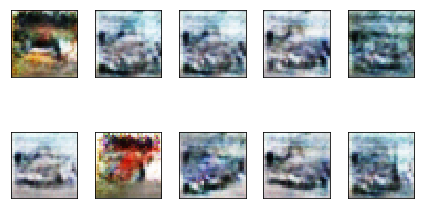

epoch = 72/300, d_loss=0.266, g_loss=4.222                                                                                                                      
epoch = 73/300, d_loss=0.194, g_loss=3.685                                                                                                                       
epoch = 74/300, d_loss=0.210, g_loss=3.921                                                                                                                      
epoch = 75/300, d_loss=0.244, g_loss=3.763                                                                                                                      
epoch = 76/300, d_loss=0.172, g_loss=0.098                                                                                                                      
epoch = 77/300, d_loss=0.187, g_loss=1.620                                                                                                                      
epoch = 78/300, d_loss=0.183, g_l

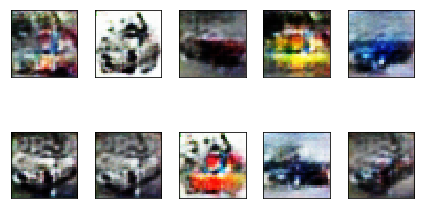

epoch = 82/300, d_loss=0.188, g_loss=2.084                                                                                                                      
epoch = 83/300, d_loss=0.194, g_loss=1.546                                                                                                                       
epoch = 84/300, d_loss=0.213, g_loss=4.249                                                                                                                       
epoch = 85/300, d_loss=0.189, g_loss=1.941                                                                                                                       
epoch = 86/300, d_loss=0.196, g_loss=3.431                                                                                                                       
epoch = 87/300, d_loss=0.182, g_loss=0.961                                                                                                                       
epoch = 88/300, d_loss=0.177,

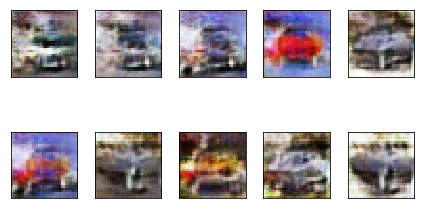

epoch = 92/300, d_loss=0.187, g_loss=2.383                                                                                                                      
epoch = 93/300, d_loss=0.187, g_loss=4.410                                                                                                                       
epoch = 94/300, d_loss=0.176, g_loss=0.178                                                                                                                      
epoch = 95/300, d_loss=0.177, g_loss=3.678                                                                                                                                                                                                                         
epoch = 96/300, d_loss=0.177, g_loss=3.752                                                                                                                      
epoch = 97/300, d_loss=0.206, g_loss=1.307                                                     

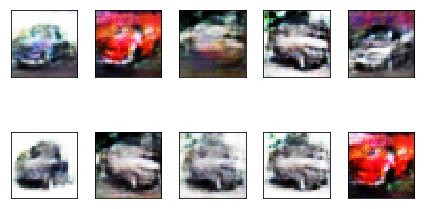

epoch = 102/300, d_loss=0.192, g_loss=1.805                                                                                                                       
epoch = 103/300, d_loss=0.181, g_loss=0.107                                                                                                                      
epoch = 104/300, d_loss=0.208, g_loss=4.414                                                                                                                      
epoch = 105/300, d_loss=0.285, g_loss=3.365                                                                                                                      
epoch = 106/300, d_loss=0.173, g_loss=1.130                                                                                                                      
epoch = 107/300, d_loss=0.267, g_loss=2.206                                                                                                                       
epoch = 108/300, d_loss=0.

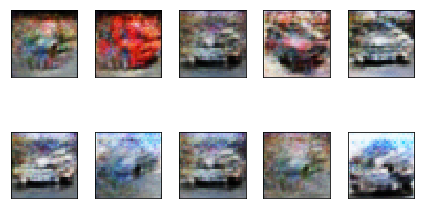

epoch = 112/300, d_loss=0.177, g_loss=0.588                                                                                                                       
epoch = 113/300, d_loss=0.183, g_loss=2.588                                                                                                                      
epoch = 114/300, d_loss=0.183, g_loss=0.439                                                                                                                      
epoch = 115/300, d_loss=0.222, g_loss=1.117                                                                                                                                                                                                                          
epoch = 116/300, d_loss=0.171, g_loss=0.940                                                                                                                      
epoch = 117/300, d_loss=0.173, g_loss=2.083                                              

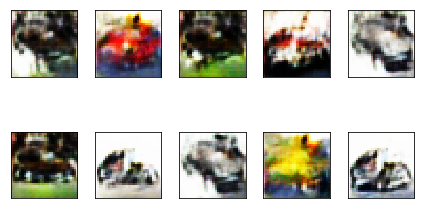

epoch = 122/300, d_loss=0.196, g_loss=0.333                                                                                                                       
epoch = 123/300, d_loss=0.200, g_loss=0.869                                                                                                                      
epoch = 124/300, d_loss=0.195, g_loss=3.104                                                                                                                       
epoch = 125/300, d_loss=0.186, g_loss=2.127                                                                                                                      
epoch = 126/300, d_loss=0.174, g_loss=3.893                                                                                                                       
epoch = 127/300, d_loss=0.182, g_loss=5.270                                                                                                                       
epoch = 128/300, d_loss=

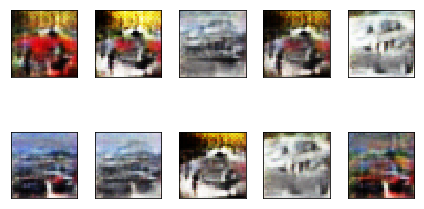

epoch = 132/300, d_loss=0.174, g_loss=4.488                                                                                                                      
epoch = 133/300, d_loss=0.212, g_loss=2.080                                                                                                                      
epoch = 134/300, d_loss=0.197, g_loss=4.801                                                                                                                      
epoch = 135/300, d_loss=0.544, g_loss=7.422                                                                                                                      
epoch = 136/300, d_loss=0.184, g_loss=0.575                                                                                                                      
epoch = 137/300, d_loss=0.279, g_loss=2.028                                                                                                                      
epoch = 138/300, d_loss=0.17

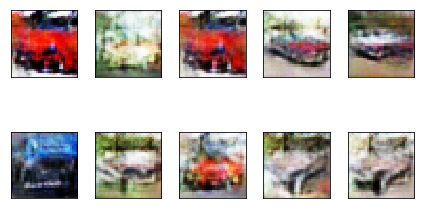

epoch = 142/300, d_loss=0.183, g_loss=1.412                                                                                                                      
epoch = 143/300, d_loss=0.209, g_loss=2.089                                                                                                                      
epoch = 144/300, d_loss=0.193, g_loss=3.645                                                                                                                      
epoch = 145/300, d_loss=0.180, g_loss=1.938                                                                                                                      
epoch = 146/300, d_loss=0.187, g_loss=1.238                                                                                                                      
epoch = 147/300, d_loss=0.178, g_loss=2.490                                                                                                                      
epoch = 148/300, d_loss=0.17

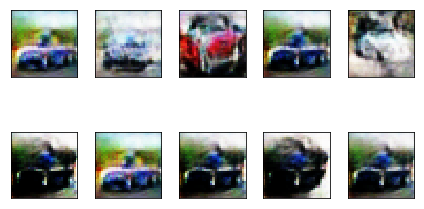

epoch = 152/300, d_loss=0.201, g_loss=0.599                                                                                                                      
epoch = 153/300, d_loss=0.195, g_loss=4.573                                                                                                                      
epoch = 154/300, d_loss=0.172, g_loss=0.377                                                                                                                      
epoch = 155/300, d_loss=0.186, g_loss=5.342                                                                                                                       
epoch = 156/300, d_loss=0.179, g_loss=4.355                                                                                                                      
epoch = 157/300, d_loss=0.183, g_loss=3.562                                                                                                                       
epoch = 158/300, d_loss=0.

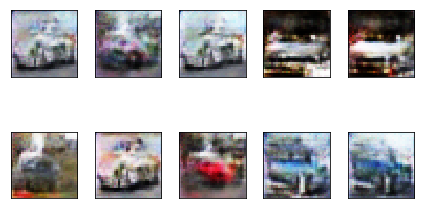

epoch = 162/300, d_loss=0.208, g_loss=3.639                                                                                                                      
epoch = 163/300, d_loss=0.209, g_loss=1.293                                                                                                                      
epoch = 164/300, d_loss=0.180, g_loss=2.668                                                                                                                      
epoch = 165/300, d_loss=0.174, g_loss=1.653                                                                                                                      
epoch = 166/300, d_loss=0.188, g_loss=3.656                                                                                                                      
epoch = 167/300, d_loss=0.343, g_loss=9.207                                                                                                                       
epoch = 168/300, d_loss=0.2

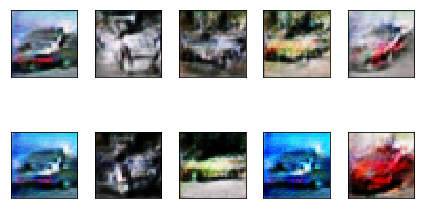

epoch = 172/300, d_loss=0.200, g_loss=3.129                                                                                                                      
epoch = 173/300, d_loss=0.170, g_loss=0.245                                                                                                                      
epoch = 174/300, d_loss=0.175, g_loss=2.523                                                                                                                      
epoch = 175/300, d_loss=0.184, g_loss=3.716                                                                                                                      
epoch = 176/300, d_loss=0.175, g_loss=4.317                                                                                                                       
epoch = 177/300, d_loss=0.174, g_loss=3.582                                                                                                                      
epoch = 178/300, d_loss=0.2

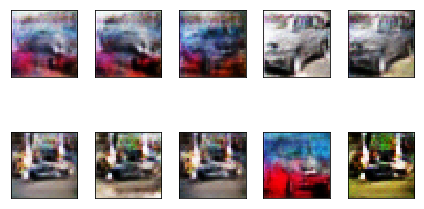

epoch = 182/300, d_loss=0.179, g_loss=2.824                                                                                                                      
epoch = 183/300, d_loss=0.172, g_loss=1.815                                                                                                                       
epoch = 184/300, d_loss=0.168, g_loss=2.532                                                                                                                      
epoch = 185/300, d_loss=0.193, g_loss=3.740                                                                                                                      
epoch = 186/300, d_loss=0.181, g_loss=1.054                                                                                                                      
epoch = 187/300, d_loss=0.190, g_loss=1.417                                                                                                                       
epoch = 188/300, d_loss=0.

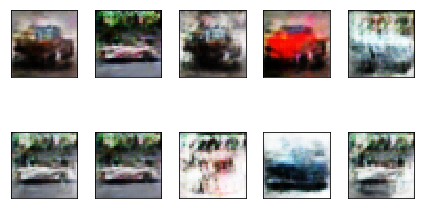

epoch = 192/300, d_loss=0.188, g_loss=2.748                                                                                                                       
epoch = 193/300, d_loss=0.171, g_loss=5.949                                                                                                                      
epoch = 194/300, d_loss=0.171, g_loss=3.378                                                                                                                       
epoch = 195/300, d_loss=0.810, g_loss=5.929                                                                                                                      
epoch = 196/300, d_loss=0.207, g_loss=2.990                                                                                                                                                                                                                         
epoch = 197/300, d_loss=0.180, g_loss=5.143                                              

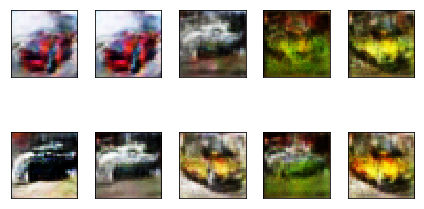

epoch = 202/300, d_loss=0.182, g_loss=2.841                                                                                                                      
epoch = 203/300, d_loss=0.216, g_loss=2.871                                                                                                                      
epoch = 204/300, d_loss=0.190, g_loss=1.210                                                                                                                      
epoch = 205/300, d_loss=0.179, g_loss=5.578                                                                                                                      
epoch = 206/300, d_loss=0.224, g_loss=1.994                                                                                                                      
epoch = 207/300, d_loss=0.172, g_loss=5.197                                                                                                                       
epoch = 208/300, d_loss=0.1

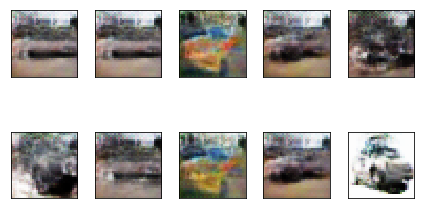

epoch = 212/300, d_loss=0.188, g_loss=2.958                                                                                                                      
epoch = 213/300, d_loss=0.211, g_loss=5.701                                                                                                                       
epoch = 214/300, d_loss=0.224, g_loss=0.989                                                                                                                      
epoch = 215/300, d_loss=0.170, g_loss=0.589                                                                                                                      
epoch = 216/300, d_loss=0.175, g_loss=16.118                                                                                                                      
epoch = 217/300, d_loss=0.180, g_loss=1.115                                                                                                                      
epoch = 218/300, d_loss=0.

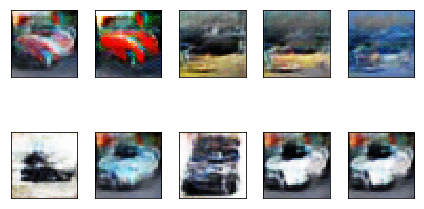

epoch = 222/300, d_loss=0.206, g_loss=3.242                                                                                                                       
epoch = 223/300, d_loss=0.178, g_loss=1.433                                                                                                                       
epoch = 224/300, d_loss=0.255, g_loss=4.028                                                                                                                      
epoch = 225/300, d_loss=0.197, g_loss=2.212                                                                                                                       
epoch = 226/300, d_loss=0.171, g_loss=10.422                                                                                                                      
epoch = 227/300, d_loss=0.243, g_loss=3.316                                                                                                                      
epoch = 228/300, d_loss=

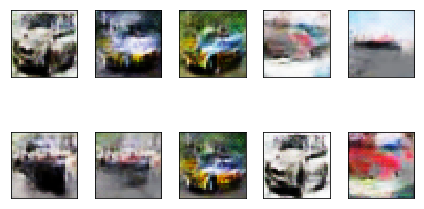

epoch = 232/300, d_loss=0.176, g_loss=3.913                                                                                                                      
epoch = 233/300, d_loss=0.234, g_loss=3.788                                                                                                                      
epoch = 234/300, d_loss=0.172, g_loss=0.885                                                                                                                      
epoch = 235/300, d_loss=0.190, g_loss=1.952                                                                                                                       
epoch = 236/300, d_loss=0.183, g_loss=1.412                                                                                                                      
epoch = 237/300, d_loss=0.177, g_loss=3.885                                                                                                                      
epoch = 238/300, d_loss=0.1

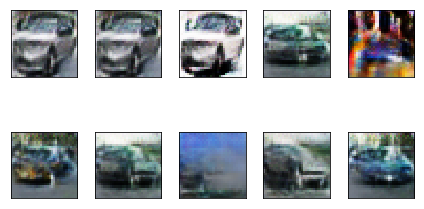

epoch = 242/300, d_loss=0.173, g_loss=0.747                                                                                                                      
epoch = 243/300, d_loss=0.177, g_loss=2.898                                                                                                                      
epoch = 244/300, d_loss=0.213, g_loss=3.147                                                                                                                      
epoch = 245/300, d_loss=0.179, g_loss=2.658                                                                                                                       
epoch = 246/300, d_loss=0.174, g_loss=3.650                                                                                                                      
epoch = 247/300, d_loss=0.177, g_loss=3.764                                                                                                                      
epoch = 248/300, d_loss=0.1

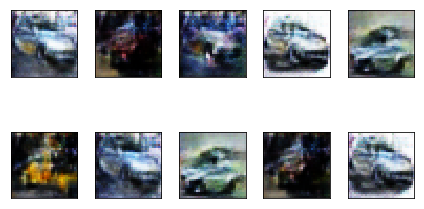

epoch = 252/300, d_loss=0.179, g_loss=1.288                                                                                                                       
epoch = 253/300, d_loss=0.182, g_loss=4.460                                                                                                                      
epoch = 254/300, d_loss=0.181, g_loss=3.747                                                                                                                       
epoch = 255/300, d_loss=0.178, g_loss=4.874                                                                                                                      
epoch = 256/300, d_loss=0.179, g_loss=4.741                                                                                                                      
epoch = 257/300, d_loss=0.174, g_loss=4.399                                                                                                                       
epoch = 258/300, d_loss=0

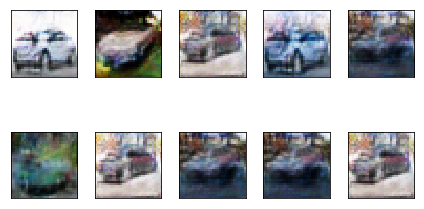

epoch = 262/300, d_loss=0.195, g_loss=3.822                                                                                                                      
epoch = 263/300, d_loss=0.193, g_loss=1.214                                                                                                                      
epoch = 264/300, d_loss=0.180, g_loss=9.064                                                                                                                      
epoch = 265/300, d_loss=0.185, g_loss=4.677                                                                                                                      
epoch = 266/300, d_loss=0.189, g_loss=3.192                                                                                                                      
epoch = 267/300, d_loss=0.176, g_loss=3.492                                                                                                                                                   

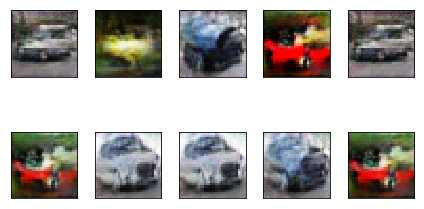

epoch = 272/300, d_loss=0.193, g_loss=4.238                                                                                                                      
epoch = 273/300, d_loss=0.181, g_loss=3.974                                                                                                                      
epoch = 274/300, d_loss=0.182, g_loss=2.984                                                                                                                      
epoch = 275/300, d_loss=0.175, g_loss=4.173                                                                                                                      
epoch = 276/300, d_loss=0.176, g_loss=3.786                                                                                                                      
epoch = 277/300, d_loss=0.172, g_loss=0.286                                                                                                                      
epoch = 278/300, d_loss=0.21

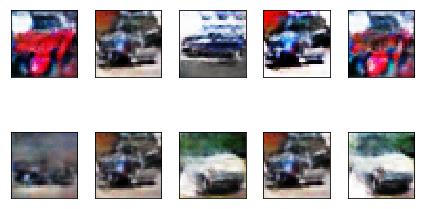

epoch = 282/300, d_loss=0.176, g_loss=1.893                                                                                                                      
epoch = 283/300, d_loss=0.176, g_loss=0.779                                                                                                                      
epoch = 284/300, d_loss=0.168, g_loss=1.307                                                                                                                       
epoch = 285/300, d_loss=0.486, g_loss=1.091                                                                                                                       
epoch = 286/300, d_loss=0.185, g_loss=6.864                                                                                                                      
epoch = 287/300, d_loss=0.192, g_loss=3.016                                                                                                                                                 

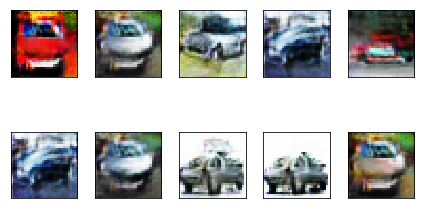

epoch = 292/300, d_loss=0.168, g_loss=2.845                                                                                                                       
epoch = 293/300, d_loss=0.192, g_loss=2.903                                                                                                                       
epoch = 294/300, d_loss=0.173, g_loss=2.495                                                                                                                      
epoch = 295/300, d_loss=0.173, g_loss=3.984                                                                                                                      
epoch = 296/300, d_loss=0.181, g_loss=4.666                                                                                                                       
epoch = 297/300, d_loss=0.175, g_loss=2.598                                                                                                                      


In [ ]:
# 训练轮次
epochs = 300
# 每批数量
batch_size = 32
# 查阅资料发现设置smooth参数会有较好的效果
smooth = 0.1
# G训练时使得D(G(z))为real
# D训练时使得D(G(z))为fake，D(X_train[i])为real
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))
# 用来存储生成器和判别器的损失
d_loss = []
g_loss = []
# 开始训练
for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):        
        
        # 训练判别器
        discriminator.trainable = True        
        # 输入真实数据，期望结果为real
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,y=real * (1 - smooth))       
        # 输入生成器生成的数据，期望结果为fake
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
        # 判别器损失，之后与生成器损失放在同一图中，便于观察乘以系数 0.5
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # 训练DCGAN（即生成器）
        discriminator.trainable = False
        # 输入生成器生成的数据，期望结果为real
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()